# Heading correlation

In [10]:
import os
import pandas as pd
import wandb
from tqdm import tqdm

api = wandb.Api()

runs = api.runs("pmin/crcns-train_heading.py", 
                {"$and": 
                 [
                     {"state": "finished"},
                ]
                }
               )

features = {}
heading_results = []
for run in tqdm(runs):
    if run.config['features'] in features:
        continue
    
    try:
        os.remove('tuning_loss.npy')
    except FileNotFoundError:
        pass
    
    try:
        os.remove('report_loss.npy')
    except FileNotFoundError:
        pass
    
    for f in run.files():
        f.download(replace=True)

    try:
        tuning_loss = np.load('tuning_loss.npy')
    except FileNotFoundError:
        continue
        
    report_loss = np.load('report_loss.npy')
    
    try:
        layer_names = sorted(run.summary['best_report_loss'].keys())
    except:
        layer_names = [f'layer{i:02d}' for i in range(tuning_loss.shape[0])]
    
    best_report_loss = np.zeros((tuning_loss.shape[0], tuning_loss.shape[2]))
    for i in range(tuning_loss.shape[0]):
        minpos = tuning_loss[i, :, :].mean(axis=1).argmin()
        best_report_loss[i, :] = report_loss[i, minpos, :]
    
    heading_results += [
        {'features': friendly_names[run.config['features']],
         'layer_name': name,
         'layer': int(name[-2:]),
         'heading_loss': best_report_loss[i, :].mean(),
         'heading_loss_pitch': best_report_loss[i, 0].mean(),
         'heading_loss_yaw': best_report_loss[i, 1].mean(),
         'heading_loss_rotation_pitch': best_report_loss[i, 2].mean(),
         'heading_loss_rotation_yaw': best_report_loss[i, 3].mean(),
         'heading_loss_speed': best_report_loss[i, 4].mean(),
        } for i, name in enumerate(layer_names)
    ]
    features[run.config['features']] = 1
    
df_heading = pd.DataFrame(heading_results)

100%|██████████| 17/17 [00:33<00:00,  1.95s/it]


In [9]:
df.head()

,key,family,dataset,subset,features,layer,features_layer,report_corr,max_r2,rnorm,subset_overall
0,I3D_layer00_mst_norm_neutralbg_0,SlowFast,mst,0,i3d,0,i3d_00,0.271957,0.961184,0.282940,36
1,I3D_layer00_mst_norm_neutralbg_1,SlowFast,mst,1,i3d,0,i3d_00,-0.139558,0.795850,-0.175357,36
2,I3D_layer00_mst_norm_neutralbg_10,SlowFast,mst,10,i3d,0,i3d_00,0.094029,0.867711,0.108365,36
3,I3D_layer00_mst_norm_neutralbg_11,SlowFast,mst,11,i3d,0,i3d_00,0.029276,0.745130,0.039290,36
4,I3D_layer00_mst_norm_neutralbg_12,SlowFast,mst,12,i3d,0,i3d_00,0.408582,0.984761,0.414905,36


In [19]:
~df_with_heading.features.isin(['cpc_airsim', 'dorsalnet'])

0      False
1      False
2      False
3      False
4      False
       ...  
218     True
219     True
220     True
221     True
222     True
Name: features, Length: 223, dtype: bool

\begin{tabular}{lrrrrrr}
\toprule
metric &  heading\_loss &  heading\_loss\_pitch &  heading\_loss\_yaw &  heading\_loss\_rotation\_pitch &  heading\_loss\_rotation\_yaw &  heading\_loss\_speed \\
area &               &                     &                   &                              &                            &                     \\
\midrule
v1   &         -0.39 &                0.13 &              0.11 &                        -0.36 &                      -0.54 &               -0.12 \\
mt   &         -0.66 &               -0.05 &             -0.02 &                        -0.51 &                      -0.64 &               -0.40 \\
mst  &         -0.53 &                0.05 &              0.05 &                        -0.51 &                      -0.69 &               -0.13 \\
\bottomrule
\end{tabular}



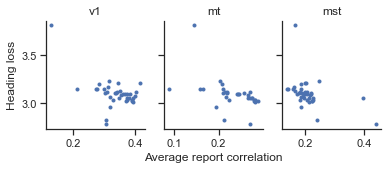

In [126]:
from scipy.stats import spearmanr, pearsonr

plt.figure(figsize=(6, 2))

dmap = {'pvc1': 'v1', 'pvc4': 'v1', 'mt1': 'mt', 'mt2': 'mt', 'mst': 'mst'}

df['area'] = df.dataset.map(lambda x: dmap[x])

results = []

for i, area in enumerate(['v1', 'mt', 'mst']):

    df_average = df.groupby(['features', 'area', 'layer']).rnorm.mean().reset_index()
    df_with_heading = pd.merge(df_average, df_heading, left_on=('features', 'layer'), right_on=('features', 'layer'))

    df_with_heading = df_with_heading[~df_with_heading.features.isin(['cpc_airsim', 'dorsalnet'])]
    df_ = df_with_heading.query(f'area == "{area}"')
    plt.subplot(131 + i)
    
    plt.plot(df_.rnorm, df_.heading_loss, '.')
    if i == 1:
        plt.xlabel('Average report correlation')
    if i == 0:
        plt.ylabel('Heading loss')
    else:
        plt.yticks([3.0, 3.5], ['', ''])
    plt.title(area)
    
    for metric in ['heading_loss', 'heading_loss_pitch', 'heading_loss_yaw', 'heading_loss_rotation_pitch', 'heading_loss_rotation_yaw', 'heading_loss_speed']:
        r, p = spearmanr(df_.rnorm.values, df_[metric].values)
        results.append({'area': area,
                        'r': r,
                        'p': p,
                        'metric': metric})
    sns.despine()

plt.savefig('/home/pmin/paper-assets/heading-loss_correlation-v1-mt-mst.pdf', bbox_inches='tight')

#import statsmodels
#import statsmodels.api as sm
#X = np.stack([df_.report_corr.values, np.ones(df_.report_corr.values.shape)], axis=1)
#rlm_model = sm.RLM(df_.heading_loss.values.reshape((-1, 1)), X, M=sm.robust.norms.HuberT())
#results = rlm_model.fit()
#results.summary()
df__ = pd.DataFrame(results).pivot('area', 'metric', 'r')
df__ = df__[['heading_loss', 'heading_loss_pitch', 'heading_loss_yaw', 'heading_loss_rotation_pitch', 'heading_loss_rotation_yaw', 'heading_loss_speed']].loc[['v1', 'mt', 'mst']]
print(df__.to_latex(float_format="%.2f"))
